In [315]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [316]:
#Read the dataframe. Columns are Date, Conf
df=pd.read_csv('case_time_series1.csv')
#Setting the index as Dates instead of numbers.
df.index=pd.DatetimeIndex(df['Date']+np.array(df.shape[0]*['-2020']))

In [317]:
#Store post-lockdown data
lock=df['25-Mar-2020':]

In [318]:
#data1 is for dataset 1, data2 is for dataset 2. test_values and test_dates are the last 7 days testing data and corr. dates
data1=df[:][:-7]
data2=lock[:][:-7]
test_values=df['Conf'][-7:]
test_dates=df['Date'][-7:]

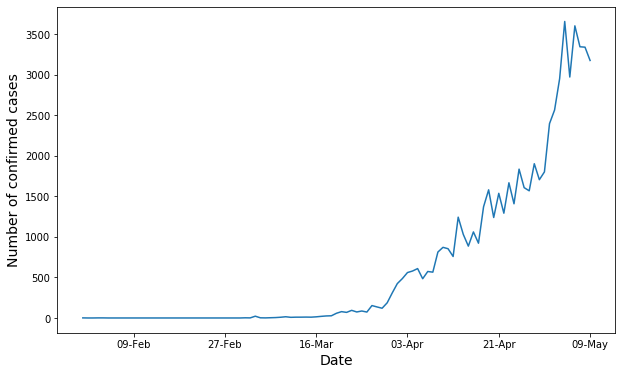

In [319]:
from statsmodels.graphics import tsaplots
#Datatype 1
fig,ax=plt.subplots(figsize=(10,6))
plt.plot(data1['Conf'])
ax.set_xlabel('Date',fontsize=14)
ax.set_ylabel('Number of confirmed cases',fontsize=14)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=18))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))

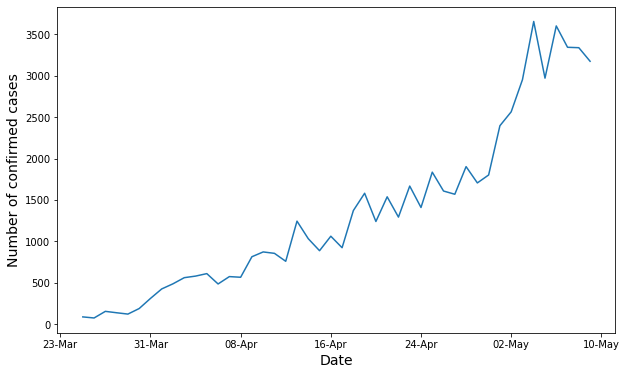

In [320]:
#Datatype 2
fig,ax=plt.subplots(figsize=(10,6))
plt.plot(data2['Conf'])
ax.set_xlabel('Date',fontsize=14)
ax.set_ylabel('Number of confirmed cases',fontsize=14)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=8))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))

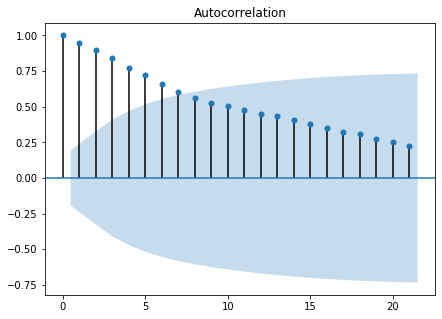

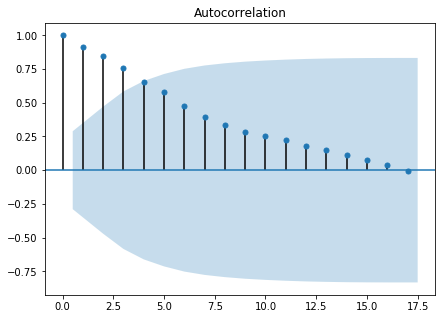

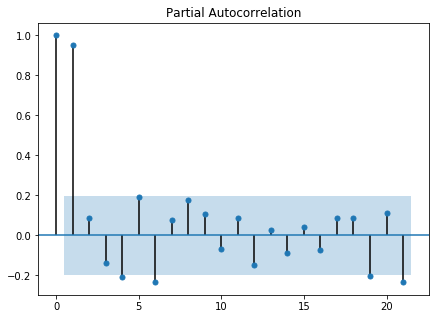

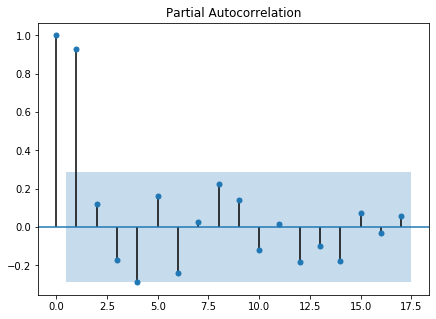

In [321]:
from pylab import rcParams

rcParams['figure.figsize']=7,5
_=tsaplots.plot_acf(data1['Conf'])
_=tsaplots.plot_acf(data2['Conf'])
_=tsaplots.plot_pacf(data1['Conf'])
_=tsaplots.plot_pacf(data2['Conf'])

In [323]:
#pip install pmdarima if not installed. 
import pmdarima as pm
from pmdarima.arima import ndiffs
#tests to determine d parameter. For dataset1

n_adf1 = ndiffs(data1['Conf'], test='adf') 
n_kpss1 = ndiffs(data1['Conf'], test='kpss')
n_pp1 = ndiffs(data1['Conf'], test='pp') 
diff1=max(n_adf1,n_kpss1,n_pp1)

#tests to determine d parameter. For dataset2

n_adf2 = ndiffs(data2['Conf'], test='adf') 
n_kpss2 = ndiffs(data2['Conf'], test='kpss')
n_pp2 = ndiffs(data2['Conf'], test='pp') 

diff2=max(n_adf2,n_kpss2,n_pp2)

In [324]:
#Auto ARIMA models for dataset 1 and 2, stepwise search
auto1=pm.auto_arima(data1['Conf'], d=diff1 ,seasonal=False, stepwise=True, suppress_warnings=True,error_action="ignore",
                 max_p=3, max_order=None).order
auto2=pm.auto_arima(data2['Conf'], d=diff2 ,seasonal=False, stepwise=True, suppress_warnings=True,error_action="ignore",
                 max_p=3, max_order=None).order

In [325]:
from statsmodels.tsa.arima_model import ARIMA
#using the auto order of dataset 1 to get ARIMA model Datatype 1 and ARIMA model Datatype 2
result1=ARIMA(data1['Conf'],order=auto1).fit()
result2=ARIMA(data2['Conf'],order=auto2).fit()

In [326]:
#forecasts for the models are calculated
forecast1=result1.forecast(steps=7)[0]
forecast2=result2.forecast(steps=7)[0]

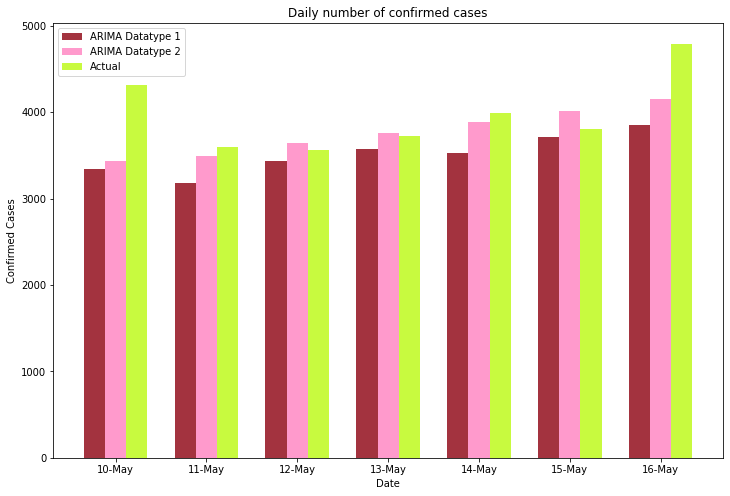

In [327]:
#Forecasts for ARIMA models are plotted against actual data
index=np.arange(7)
fig, ax = plt.subplots()
opacity=0.8
bar_width=0.233
fig.set_size_inches(12,8)  
plt.bar(index, forecast1, bar_width,
alpha=opacity,color='xkcd:crimson',label='ARIMA Datatype 1')
plt.bar(index+bar_width, forecast2, bar_width,
alpha=opacity,color='xkcd:pink',label='ARIMA Datatype 2')

plt.bar(index + 2*bar_width, test_values, bar_width,
alpha=opacity,color='xkcd:yellowgreen',label='Actual')

plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Daily number of confirmed cases')
plt.legend()
plt.xticks(index+bar_width, (test_dates))

plt.show()

In [328]:
#get residue of ARIMA model 1 and 2
resid1=result1.resid
resid2=result2.resid

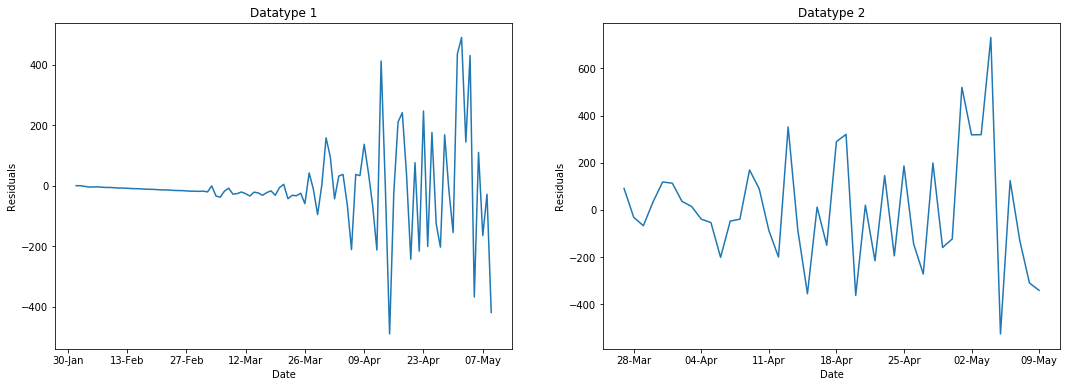

In [329]:
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
ax1=plt.subplot(121)
plt.xlabel('Date')
plt.ylabel('Residuals')
ax1.set_title("Datatype 1")
plt.plot(resid1)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
ax2=plt.subplot(122)
plt.xlabel('Date')
plt.ylabel('Residuals')
ax2.set_title("Datatype 2")
plt.plot(resid2)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))


In [330]:
from numpy import fft

In [331]:
#Fourier Extrapolation function to fit residuals
def fourier_extrapolation(x):
    n = x.size
    n_harm = int(np.ceil(10*np.log10(n)))       #choosing number of wave components proportional to log(size)
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)                     # find linear trend in x
    x_notrend = x - p[0] * t                    # detrended x
    x_freqdom = fft.fft(x_notrend)              # detrended x in frequency domain
    f = fft.fftfreq(n)                          # frequencies
    indexes = list(range(1,n//2+1))
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))
    indexes.reverse()                           #sorting f1 to fn/2 according to higher amplitude
    indexes=[0,*indexes[:n_harm]]   
    outsig=np.zeros(n)                          #initialising output frequency signal
    outsig[:n_harm+1]=x_freqdom[indexes]
    outsig[n//2+1:]=x_freqdom[n//2+1:]          #final output frequency signal
    return np.abs(fft.ifft(outsig)) + p[0] * t,p[0]   #return after performing ifft and retrending, 
resid1_fourier,p1=fourier_extrapolation(resid1)
resid2_fourier,p2=fourier_extrapolation(resid2)
#p1,p2 contain respective linear trends found

In [332]:
#fourier extrapolated residue adjusted in forecast
forecast1f=forecast1+resid1_fourier[:7]+(len(resid1)*p1)
forecast2f=forecast2+resid2_fourier[:7]+(len(resid2)*p2)


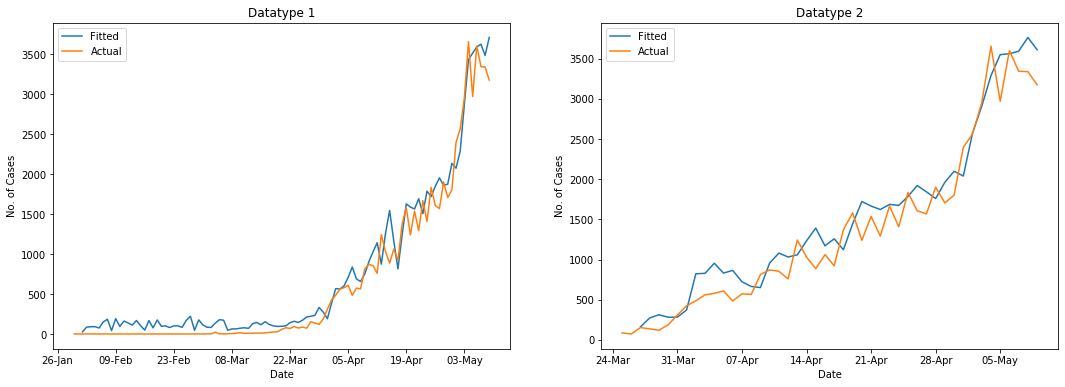

In [333]:
#in-sample forecasts for the hybrid model
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
ax1=plt.subplot(121)
plt.xlabel('Date')
plt.ylabel('No. of Cases')
ax1.set_title("Datatype 1")
plt.plot(result1.predict(typ='levels')+resid1_fourier,label="Fitted")
#plt.plot(result1.predict(typ='levels'),label="ARIMA")
plt.plot(data1['Conf'],label="Actual")
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
plt.legend()
ax2=plt.subplot(122)
plt.plot(result2.predict(typ='levels')+resid2_fourier,label="Fitted")
#plt.plot(result1.predict(typ='levels'),label="ARIMA")
plt.plot(data2['Conf'],label="Actual")
plt.xlabel('Date')
plt.ylabel('No. of Cases')
ax2.set_title("Datatype 2")
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
plt.legend()

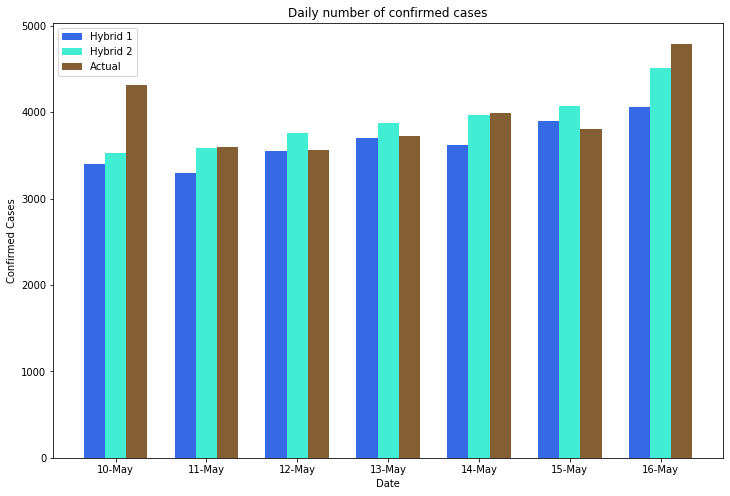

In [334]:
#Comparing hybrid 1 and hybrid 2 forecasts with actual
index=np.arange(7)
fig, ax = plt.subplots()
opacity=0.8
bar_width=0.233
fig.set_size_inches(12,8)  
plt.bar(index, forecast1f, bar_width,
alpha=opacity,color='xkcd:blue',label='Hybrid 1')
plt.bar(index+bar_width, forecast2f, bar_width,
alpha=opacity,color='xkcd:aqua',label='Hybrid 2')

plt.bar(index + 2*bar_width, test_values, bar_width,
alpha=opacity,color='xkcd:brown',label='Actual')

plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Daily number of confirmed cases')
plt.legend()
plt.xticks(index+bar_width, (test_dates))

plt.show()

In [335]:
#Calculating Errors for Dataset1, ARIMA model
mse = mean_squared_error(test_values, forecast1)
rmse = np.sqrt(mse)
mae= np.mean(np.abs(test_values-forecast1))
print('DATASET 1: ARIMA')
print('RMSE:',rmse,'MAE:',mae)
#Calculating Errors for Dataset2, ARIMA model
mse = mean_squared_error(test_values, forecast2)
rmse = np.sqrt(mse)
mae= np.mean(np.abs(test_values-forecast2))
print('DATASET 2: ARIMA')
print('RMSE:',rmse,'MAE:',mae)
#Calculating Errors for Dataset1, Hybrid model
mse = mean_squared_error(test_values, forecast1f)
rmse = np.sqrt(mse)
mae= np.mean(np.abs(test_values-forecast1f))
print('DATASET 1: HYBRID')
print('RMSE:',rmse,'MAE:',mae)
#Calculating Errors for Dataset2, Hybrid model
mse = mean_squared_error(test_values, forecast2f)
rmse = np.sqrt(mse)
mae= np.mean(np.abs(test_values-forecast2f))
print('DATASET 2: HYBRID')
print('RMSE:',rmse,'MAE:',mae)

DATASET 1: ARIMA
RMSE: 569.8266130470763 MAE: 452.0162073712262
DATASET 2: ARIMA
RMSE: 424.31741231320984 MAE: 292.36964466265607
DATASET 1: HYBRID
RMSE: 479.3091795522504 MAE: 348.3456979830561
DATASET 2: HYBRID
RMSE: 344.0750907628489 MAE: 242.96000985142396


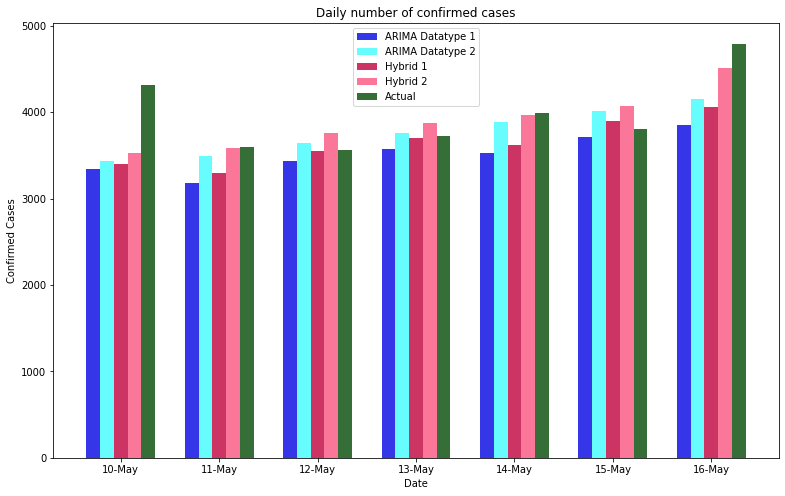

In [336]:
#Comparing forecasts of all 4 models with actual
index=np.arange(7)
fig, ax = plt.subplots()
opacity=0.8
bar_width=0.14
fig.set_size_inches(13,8)  
plt.bar(index, forecast1, bar_width,
alpha=opacity,color='xkcd:pure blue',label='ARIMA Datatype 1')
plt.bar(index+bar_width, forecast2, bar_width,
alpha=opacity,color='xkcd:bright cyan',label='ARIMA Datatype 2')
plt.bar(index+2*bar_width, forecast1f, bar_width,
alpha=opacity,color='xkcd:rose red',label='Hybrid 1')
plt.bar(index+3*bar_width, forecast2f, bar_width,
alpha=opacity,color='xkcd:warm pink',label='Hybrid 2')

plt.bar(index + 4*bar_width, test_values, bar_width,
alpha=opacity,color='xkcd:bottle green',label='Actual')

plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Daily number of confirmed cases')
plt.legend()
plt.xticks(index+2*bar_width, (test_dates))

plt.show()